# Importing the modules

In [1]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Loading the dataset

In [2]:
def loadIndianPinesData():
    data_path = os.path.join('F:\main_project\Datasets')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

In [3]:
data_set, gt=loadIndianPinesData()

# Splitting the dataset

In [4]:
train_fraction = 0.85
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 8705.
Number of test samples = 1543.


A portion of training data can optionally be set aside for validation.

In [5]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

In [6]:
data_set = util.reduce_dim(img_data=data_set, n_components=.999)
data_set.shape


(145, 145, 69)

## Creating input to MLP

In [7]:
patch_size=1
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

## Creating an MLP neural network model


In [8]:
units_1 = 2**8
drop_rate =0.35
num_catg = len(catg_labels)
input_shape = (patch_size, patch_size, data_set.shape[-1])

# Building a MLP network model
nn_model = models.Sequential()
#
# dense_input
nn_model.add(layer=layers.Dense(units=data_set.shape[2], activation='relu',
                                input_shape=input_shape))
# flatten_1, changes input shape from (1,1,num_band) to (num_band,)
nn_model.add(layer=layers.Flatten())
# dense_1
nn_model.add(layer=layers.Dense(units=units_1, activation='relu')) 
# dropout_1
nn_model.add(layer=layers.Dropout(drop_rate))
# dense_output
nn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 69)          4830      
_________________________________________________________________
flatten_1 (Flatten)          (None, 69)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               17920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4112      
Total params: 26,862
Trainable params: 26,862
Non-trainable params: 0
_________________________________________________________________


## Training model 

In [9]:
lr = 1e-4
batch_size = 2**3

# Compiling the modele
nn_model.compile(optimizer=optimizers.RMSprop(lr=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])

# Training the model
nn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                       epochs=50, validation_data=(val_input, y_val), verbose=False)



## Model performance evaluation

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import spectral
import matplotlib

In [11]:
def reports (X_test,y_test):
    Y_pred =nn_model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    avgAcc=[]
    classArray=[]
    for c in range(len(confusion)):
        recallSoc=confusion[c][c]/sum(confusion[c])
        classArray+=[recallSoc]
    avgAcc.append(sum(classArray)/len(classArray))
    avg_accuracy=np.mean(avgAcc)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    overall_loss, overall_accu = nn_model.evaluate(X_test, y_test, verbose=False)
    
    
    return classification, confusion, kappa,  overall_accu, avg_accuracy


In [12]:
classification, confusion,  kappa, overall_accuracy, avg_accuracy = reports(test_input,y_test)
print('Classification_report:\n')
print('{}\n'.format(classification))
print('Confusion_matrix :\n')
print('{}\n'.format(confusion))
print('Kappa value : {}\n'.format(kappa))
print('Overall accuracy : {}\n'.format(overall_accuracy))
print('Average_accuracy : {}\n'.format(avg_accuracy))

Classification_report:

                              precision    recall  f1-score   support

                     Alfalfa       0.83      0.71      0.77         7
                 Corn-notill       0.69      0.72      0.70       215
                Corn-mintill       0.73      0.38      0.50       125
                        Corn       0.72      0.50      0.59        36
               Grass-pasture       0.97      0.90      0.94        73
                 Grass-trees       0.95      0.96      0.95       110
         Grass-pasture-mowed       0.75      0.60      0.67         5
               Hay-windrowed       0.96      1.00      0.98        72
                        Oats       1.00      0.67      0.80         3
              Soybean-notill       0.84      0.53      0.65       146
             Soybean-mintill       0.66      0.87      0.75       369
               Soybean-clean       0.67      0.73      0.70        89
                       Wheat       1.00      0.97      0.98      

Text(0.5, 1.0, 'Classification Map of GroundTruth')

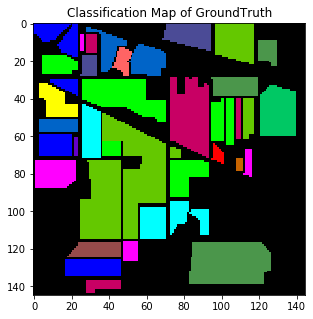

In [13]:
ground_truth = spectral.imshow(classes = gt,figsize =(5,5))
plt.title('Classification Map of GroundTruth')

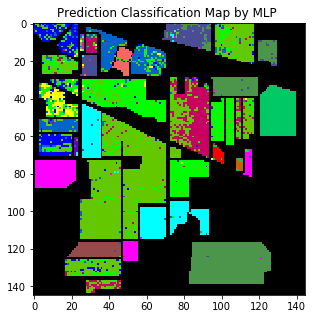

In [14]:
# Plotting predicted results
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)

partial_map = util.plot_partial_map(nn_model, gt, pixel_indices, concat_input,
                            concat_y, int_to_vector_dict, plo=False)
full_map = util.plot_full_map(nn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)

predicted_image=spectral.imshow(classes=partial_map.astype(int),figsize =(5,5),cmap= 'jet')
plt.title('Prediction Classification Map by MLP ')
plt.show()

In [15]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [16]:
df = extract_pixels(data_set, gt)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 82.56it/s]


In [17]:
df.to_csv('data_set.csv', index=False)

In [18]:
df = pd.read_csv('data_set.csv')

In [19]:
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-61,band-62,band-63,band-64,band-65,band-66,band-67,band-68,band-69,class
0,5014.905985,1456.863260,72.697049,71.204926,-435.686985,-68.840318,134.809864,-304.372455,256.432994,-66.630999,...,-27.443483,22.736123,19.374879,46.478876,23.091926,-114.144709,-50.423755,14.066993,-0.363448,3
1,5601.383743,-2023.450087,350.134661,-528.465053,148.088296,-288.359031,202.956863,240.848020,-474.857836,93.493771,...,-3.895927,7.606716,-54.531582,33.381958,-23.860197,-83.431955,-43.056906,48.733511,35.077124,3
2,5796.135442,-3090.394852,490.539929,-760.214346,259.933303,-131.611181,172.927304,205.911237,572.491978,-191.622014,...,49.191364,34.971503,72.465642,18.978080,-24.738346,-49.746001,-11.616716,82.222496,48.338355,3
3,5586.204575,-2369.376085,356.274719,-502.687155,146.554951,-306.679326,251.071095,234.966433,-314.023248,54.962246,...,19.894458,29.423946,37.537785,-0.355415,-13.863541,-14.804148,-34.104488,59.814500,74.500063,3
4,5020.990792,339.603390,-23.007525,-92.556769,-368.495443,-438.266709,502.715429,-345.536587,-188.352757,-67.506061,...,-24.895147,62.043627,90.564164,-18.239001,10.729999,-82.637590,34.887119,73.951021,14.564249,3


In [20]:
df.tail()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-61,band-62,band-63,band-64,band-65,band-66,band-67,band-68,band-69,class
21020,-7487.553326,-1805.678548,277.584390,223.237090,-73.502114,-51.766813,307.175311,-310.175152,-413.956298,100.810360,...,0.938049,31.219053,17.803901,9.364652,-41.386323,9.763238,-41.889158,-1.440326,24.899953,0
21021,-7747.524119,-1831.909102,399.489872,91.054120,-398.538463,117.590451,366.731501,-207.220528,-249.131187,6.785483,...,30.361054,51.957106,23.309180,-18.246473,-27.352688,-26.439194,-59.481880,-19.446885,14.911085,0
21022,-7369.834198,-1132.381766,398.170226,94.132258,-359.553126,105.064763,360.166953,-151.536317,147.342484,6.576994,...,33.744338,15.034361,96.300530,-3.917435,-18.804783,-1.368995,-81.040922,3.792772,-30.685325,0
21023,-6497.087239,798.240033,676.808968,-196.894558,-766.926270,452.868851,254.771214,296.950126,214.486405,16.190037,...,22.482885,6.702014,-11.389912,-21.183874,-11.260279,13.851725,1.362068,-18.580330,47.060948,0
21024,-6570.461161,346.749622,465.450797,102.213760,-552.875771,265.538888,211.911788,290.308618,357.758738,-138.505638,...,-38.615104,41.524623,10.506426,11.456124,-0.879594,30.314877,26.708517,-35.799276,9.736300,0


In [21]:
df.count()

band-1     21025
band-2     21025
band-3     21025
band-4     21025
band-5     21025
           ...  
band-66    21025
band-67    21025
band-68    21025
band-69    21025
class      21025
Length: 70, dtype: int64

In [22]:
Dataset = df.iloc[:, :-1].values

groundTruth = df.iloc[:, -1].values

In [23]:
Dataset.shape, groundTruth.shape

((21025, 69), (21025,))

In [24]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 151), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

In [25]:
print(f"Unique Class Labels: {df.loc[:, 'class'].unique()}")

Unique Class Labels: [ 3  0 15 11 12  5 10 14 16  2  4  8  6  9  1  7 13]


In [26]:
df.loc[:, 'class'].value_counts()

0     10776
11     2455
2      1428
14     1265
10      972
3       830
6       730
12      593
5       483
8       478
15      386
4       237
13      205
16       93
1        46
7        28
9        20
Name: class, dtype: int64

In [27]:
df[df['class']== 9][0:70]

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-61,band-62,band-63,band-64,band-65,band-66,band-67,band-68,band-69,class
8867,-1745.781639,338.480249,-106.233663,326.999524,496.847455,254.706320,587.717063,400.552281,-82.136272,546.855539,...,-23.513077,31.954609,26.338951,20.640984,3.002540,-38.334221,-1.883255,-73.611216,10.304080,9
8868,-1562.148554,454.659813,178.251771,346.251171,638.716358,177.436094,723.178768,400.376434,90.656469,681.012830,...,9.578671,55.488000,4.412446,-13.056341,-23.611194,-7.473705,24.444141,-7.127667,92.846664,9
9012,-1415.113630,928.612840,6.175585,-28.497323,528.164079,-224.745888,722.619249,407.173999,-94.966476,801.960101,...,-3.778756,51.037851,53.022547,-33.173840,3.355963,-46.459927,20.657193,1.499863,24.542751,9
9013,-1314.810767,879.758585,160.143337,206.171529,455.118513,-162.959424,240.102318,447.357229,328.866201,771.758514,...,-35.037883,40.849004,15.138706,-15.648145,2.987232,4.204635,38.929886,53.688642,-31.105181,9
9157,-1161.042309,1508.835815,-124.352555,-131.591307,365.884450,-229.681295,513.378401,419.823319,-265.540199,751.312508,...,5.722353,54.546034,-78.587267,-4.739027,8.438613,-41.572816,-22.641223,16.774684,15.727290,9
9158,-1338.505579,2136.552991,139.363805,-17.805473,201.030482,-685.818704,-84.786385,-34.481945,258.532475,561.191304,...,22.899865,54.892332,-12.879482,-11.631123,9.289391,-41.866095,-42.937573,-46.107671,-1.479832,9
9302,-2250.515409,1177.038264,48.118338,-283.003029,341.029462,-827.925330,17.736674,145.317675,80.014930,913.058450,...,9.250935,30.169497,-6.160334,-19.024792,9.379786,-33.992985,-13.175117,-10.435763,0.169376,9
9303,-1845.659590,2853.657428,326.477165,-271.818508,335.202544,-986.053897,-458.724266,288.737471,336.871380,9.003928,...,5.266292,8.548954,38.073202,-13.310738,-6.989899,-31.690665,-1.984974,-11.487495,-13.947158,9
9447,-1919.928262,1549.143671,-2.774933,-301.668692,293.355752,-860.056716,-128.685663,167.723181,-143.774323,724.992905,...,-8.783327,1.036729,-53.434725,-7.955104,15.316793,13.201050,51.356269,10.481377,37.274717,9
9448,-2123.347595,2919.192607,284.223645,-325.292169,250.096365,-1006.686375,-494.442214,326.463602,156.685414,16.547178,...,-1.524804,18.115975,37.099143,-10.636781,-6.658448,-13.853879,61.173101,26.664849,-35.567360,9
